Make sure to upload new_data.csv to the runtime first

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving whole_quarter.csv to whole_quarter (1).csv


In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv("new_data.csv")
df.columns

Index(['event id', 'event name', 'EVENT_START_DATETIME',
       'CLASSIFICATION_GENRE', 'CLASSIFICATION_SUB_GENRE', 'MIN_PRICE',
       'MAX_PRICE', 'ATTRACTION_NAME', 'attraction id', 'venue city',
       'venue id', 'venue address', 'venue state', 'VENUE_TIMEZONE',
       'classification type', 'classification subtype',
       'classification segment', 'classification genre',
       'classification subgenre', 'classification type.1',
       'classification subtype.1', 'scrape time'],
      dtype='object')

In [ ]:
min_price_df = df[["event id", "MIN_PRICE", "scrape time"]]
earliest_times = min_price_df.drop("MIN_PRICE", axis=1).groupby(by="event id").min().reset_index()
earliest_prices = min_price_df.merge(earliest_times, on=["event id", "scrape time"], how="right")

latest_times = min_price_df.drop("MIN_PRICE", axis=1).groupby(by="event id").max().reset_index()
latest_prices = min_price_df.merge(latest_times, on=["event id", "scrape time"], how="right")

diff_min = earliest_prices.merge(latest_prices, on="event id", how="inner", suffixes=["_early", "_late"])
diff_min["markup"] = diff_min["MIN_PRICE_late"] - diff_min["MIN_PRICE_early"]
diff_min.head()

,event id,MIN_PRICE_early,scrape time_early,MIN_PRICE_late,scrape time_late,markup
0,11AYvxaAAFjtv5,59.98,2025-02-07 20:36:49.127253,59.98,2025-02-07 20:36:49.127253,0.0
1,11FZv-oF-4ANv5,29.50,2025-02-07 20:36:47.970969,29.50,2025-02-08 18:16:58.843231,0.0
2,169ZkAx8KZA51Ckv,78.00,2025-02-07 20:36:47.955347,78.00,2025-02-07 20:36:47.955347,0.0
3,169ZkAx8KZAG1CkA,78.00,2025-02-07 20:36:47.955347,78.00,2025-02-14 05:00:02.126734,0.0
4,169ZkAx8KZAG1Ckd,79.00,2025-02-07 20:36:47.955347,79.00,2025-02-12 02:00:02.851363,0.0


In [ ]:
diff_min[diff_min["markup"] != 0].shape[0] / diff_min.shape[0]

0.06313993174061433

The above shows only 5% of all concerts had any markup/discount over time at all.

In [ ]:
num_prices = df.groupby("event id").nunique()
num_prices[num_prices["MIN_PRICE"] > 2][["MIN_PRICE"]].shape[0]

2

The above shows that only 2 concerts in our entire dataset of several hundred concerts had more than 2 unique minimum ticket prices over the time interval that we scraped their data. Of the few concerts that changed price, only 2 changed price more than once.

In [ ]:
just_event_and_price = df.dropna(subset="MAX_PRICE")[["event id", "MAX_PRICE"]]
stds = just_event_and_price.groupby("event id").std()
had_change = stds[stds["MAX_PRICE"] > 0]
had_change.shape[0] / stds.shape[0]

0.06324786324786325

The above uses the standard deviation of all maximum ticket prices for each concert to show that only 5% of the concerts in our dataset have any change in maximum ticket price.

In [ ]:
whole_quarter = pd.read_csv("whole_quarter.csv")


In [ ]:
whole_quarter.columns


Index(['Unnamed: 0', 'EVENT_ID', 'EVENT_NAME', 'EVENT_START_DATETIME',
       'EVENT_END_DATETIME', 'CLASSIFICATION_GENRE',
       'CLASSIFICATION_SUB_GENRE', 'MIN_PRICE', 'MAX_PRICE', 'ATTRACTION_NAME',
       'ATTRACTION_ID', 'VENUE_NAME', 'VENUE_ID', 'VENUE_STREET', 'VENUE_CITY',
       'VENUE_STATE_CODE', 'VENUE_TIMEZONE', 'CLASSIFICATION_TYPE',
       'CLASSIFICATION_SUB_TYPE', 'ATTRACTION_CLASSIFICATION_SEGMENT',
       'ATTRACTION_CLASSIFICATION_GENRE',
       'ATTRACTION_CLASSIFICATION_SUB_GENRE', 'ATTRACTION_CLASSIFICATION_TYPE',
       'ATTRACTION_CLASSIFICATION_SUB_TYPE', 'TRANSACTABLE', 'HOT_EVENT',
       'scrape_time'],
      dtype='object')

In [ ]:
whole_quarter.shape

(6318, 27)

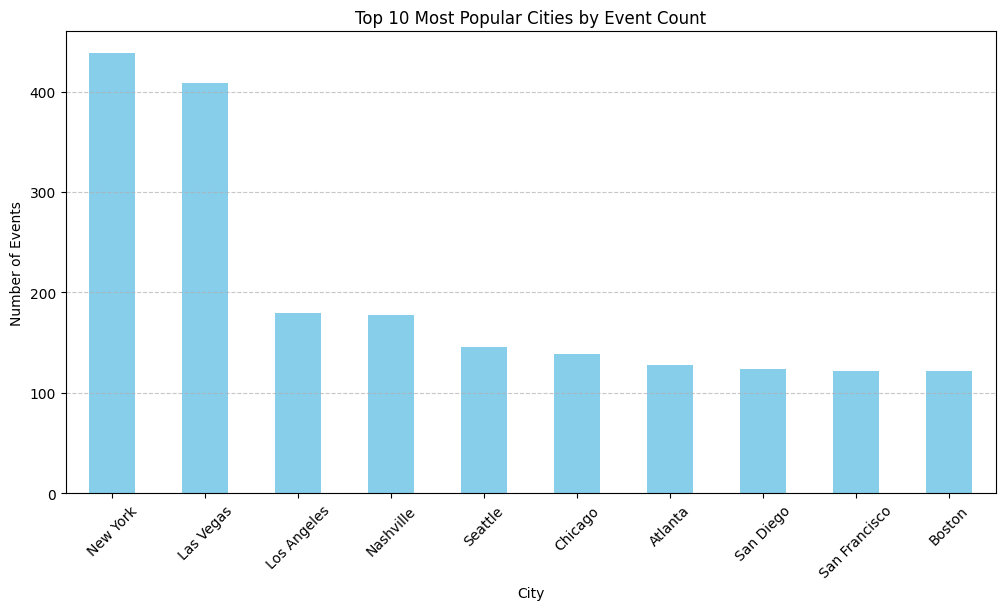

In [ ]:
import matplotlib.pyplot as plt
# Count occurrences of each city
city_counts = whole_quarter['VENUE_CITY'].value_counts().head(10)

# Plot bar graph
plt.figure(figsize=(12, 6))
city_counts.plot(kind='bar', color='skyblue')

plt.xlabel("City")
plt.ylabel("Number of Events")
plt.title("Top 10 Most Popular Cities by Event Count")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

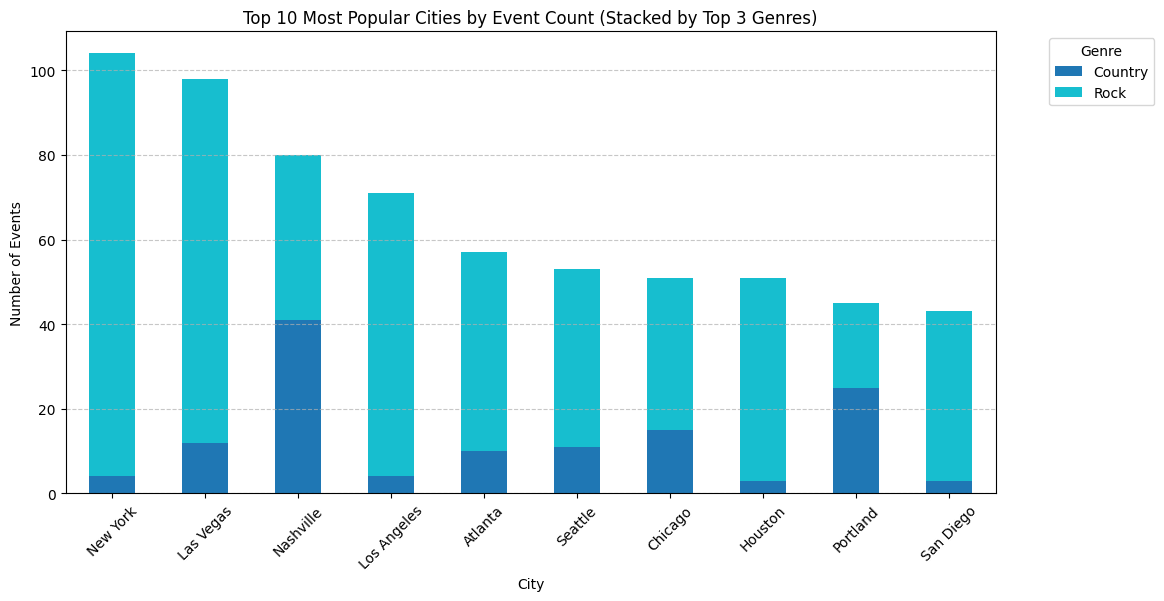

In [ ]:


# Get the top 3 genres by total event count
top_genres = whole_quarter['CLASSIFICATION_GENRE'].value_counts().head(2).index

# Filter dataset to only include events from the top 3 genres
filtered_genre_df = whole_quarter[whole_quarter['CLASSIFICATION_GENRE'].isin(top_genres)]

# Get the top 10 cities by event count
top_cities = filtered_genre_df['VENUE_CITY'].value_counts().head(10).index

# Further filter dataset to only include the top 10 cities
filtered_df = filtered_genre_df[filtered_genre_df['VENUE_CITY'].isin(top_cities)]

# Count occurrences of each genre in each city
city_genre_counts = filtered_df.pivot_table(index="VENUE_CITY", columns="CLASSIFICATION_GENRE", aggfunc="size", fill_value=0)

# Sort by total number of events
city_genre_counts = city_genre_counts.loc[top_cities]

# Plot stacked bar chart
city_genre_counts.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="tab10")

plt.xlabel("City")
plt.ylabel("Number of Events")
plt.title("Top 10 Most Popular Cities by Event Count (Stacked by Top 3 Genres)")
plt.xticks(rotation=45)
plt.legend(title="Genre", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()


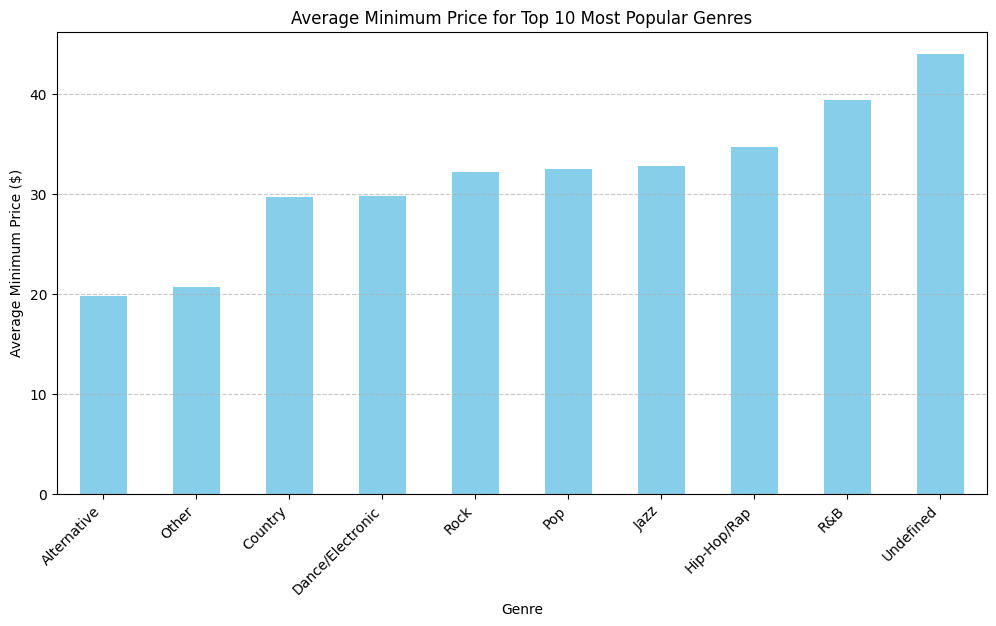

In [ ]:
whole_quarter['MIN_PRICE'] = pd.to_numeric(whole_quarter['MIN_PRICE'], errors='coerce')

# Get the top 10 most popular genres by event count
top_10_genres = whole_quarter['CLASSIFICATION_GENRE'].value_counts().head(10).index

# Filter data to only include the top 10 genres
filtered_df = whole_quarter[whole_quarter['CLASSIFICATION_GENRE'].isin(top_10_genres)]

# Calculate the average min price for the top 10 genres
avg_min_price_top_10_genres = filtered_df.groupby("CLASSIFICATION_GENRE")['MIN_PRICE'].mean().sort_values()

# Plot bar chart
plt.figure(figsize=(12, 6))
avg_min_price_top_10_genres.plot(kind="bar", color="skyblue")

plt.xlabel("Genre")
plt.ylabel("Average Minimum Price ($)")
plt.title("Average Minimum Price for Top 10 Most Popular Genres")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

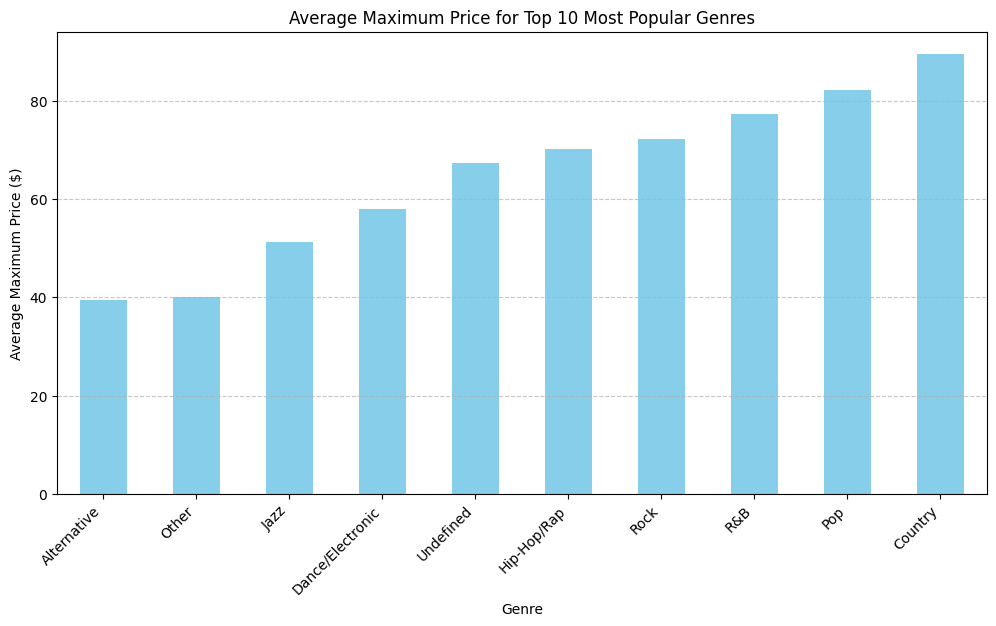

In [ ]:
whole_quarter['MAX_PRICE'] = pd.to_numeric(whole_quarter['MAX_PRICE'], errors='coerce')

# Get the top 10 most popular genres by event count
top_10_genres = whole_quarter['CLASSIFICATION_GENRE'].value_counts().head(10).index

# Filter data to only include the top 10 genres
filtered_df = whole_quarter[whole_quarter['CLASSIFICATION_GENRE'].isin(top_10_genres)]

# Calculate the average min price for the top 10 genres
avg_min_price_top_10_genres = filtered_df.groupby("CLASSIFICATION_GENRE")['MAX_PRICE'].mean().sort_values()

# Plot bar chart
plt.figure(figsize=(12, 6))
avg_min_price_top_10_genres.plot(kind="bar", color="skyblue")

plt.xlabel("Genre")
plt.ylabel("Average Maximum Price ($)")
plt.title("Average Maximum Price for Top 10 Most Popular Genres")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

In [ ]:
target_genres = ["Rock", "Country", "Pop"]

# Dictionary to store top cities for each genre
top_cities_by_genre = {}

for genre in target_genres:
    # Filter dataset for the specific genre
    genre_df = whole_quarter[whole_quarter["CLASSIFICATION_GENRE"] == genre]

    # Get the top 3 cities where this genre is most popular
    top_cities = genre_df["VENUE_CITY"].value_counts().head(3).index.tolist()

    # Store in dictionary
    top_cities_by_genre[genre] = top_cities

# Display the result
print(top_cities_by_genre)

In [ ]:
rock_df = whole_quarter[whole_quarter["CLASSIFICATION_GENRE"] == "Rock"]

# Count occurrences of each sub-genre and get the top 10
top_10_rock_subgenres = rock_df["CLASSIFICATION_SUB_GENRE"].value_counts().head(10)

# Plot bar chart
plt.figure(figsize=(12, 6))
top_10_rock_subgenres.plot(kind="bar", color="skyblue")

plt.xlabel("Rock Sub-Genre")
plt.ylabel("Number of Events")
plt.title("Top 10 Most Popular Rock Sub-Genres")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

In [ ]:
rock_df = whole_quarter[whole_quarter["CLASSIFICATION_GENRE"] == "Rock"]

# Count occurrences of each artist and get the top 5
top_5_rock_artists = rock_df["ATTRACTION_NAME"].value_counts().head(5)

# Display the result
print(top_5_rock_artists)

In [ ]:
pop_df = whole_quarter[whole_quarter["CLASSIFICATION_GENRE"] == "Pop"]

# Count occurrences of each artist and get the top 5
top_5_pop_artists = pop_df["ATTRACTION_NAME"].value_counts().head(5)

# Display the result
print(top_5_pop_artists)

In [ ]:
whole_quarter

,Unnamed: 0,EVENT_ID,EVENT_NAME,EVENT_START_DATETIME,EVENT_END_DATETIME,CLASSIFICATION_GENRE,CLASSIFICATION_SUB_GENRE,MIN_PRICE,MAX_PRICE,ATTRACTION_NAME,...,CLASSIFICATION_TYPE,CLASSIFICATION_SUB_TYPE,ATTRACTION_CLASSIFICATION_SEGMENT,ATTRACTION_CLASSIFICATION_GENRE,ATTRACTION_CLASSIFICATION_SUB_GENRE,ATTRACTION_CLASSIFICATION_TYPE,ATTRACTION_CLASSIFICATION_SUB_TYPE,TRANSACTABLE,HOT_EVENT,scrape_time
0,8,k7vGFb8zt7yQJ,Irish Celebration Starring Andy Cooney,2025-03-02 20:00:00+00:00,NaN,World,World,35.0,59.50,Andy Cooney|Mick Thomas|Sean Finnerty,...,Undefined,Undefined,Music|Music|Arts & Theatre,World|Rock|Comedy,World|Pop|Comedy,Undefined|Individual|Individual,Undefined|Musician|Comedian,True,True,2025-02-16 13:21:00.911959
1,10,vvG1VZb41CZdEo,bbno$: it's pronounced baby no money,2025-03-01 23:30:00+00:00,NaN,Hip-Hop/Rap,French Rap,22.5,22.50,bbno$|Jungle Bobby,...,Undefined,Undefined,Music|Music,Hip-Hop/Rap|Dance/Electronic,Hip-Hop/Rap|Dance/Electronic,Individual|Individual,Musician|Musician,True,False,2025-02-16 13:21:00.911959
2,11,k7vGFb45tn6T5,Jordana,2025-02-23 01:00:00+00:00,NaN,Pop,Pop,20.0,20.00,Jordana|Rachel Bobbitt,...,Undefined,Undefined,Music|Music,Pop|Alternative,Indie Pop|Alternative,Individual|Individual,Musician|Musician,True,True,2025-02-16 13:21:00.911959
3,30,vvG1VZbuKuU0dL,"Thriller, A Michael Jackson Tribute",2025-02-23 01:00:00+00:00,NaN,Undefined,Undefined,48.6,57.94,"Thriller, A Michael Jackson Tribute",...,Group,Tribute Band,Music,Undefined,Undefined,Group,Tribute Band,True,False,2025-02-16 13:21:00.911959
4,31,1AvfZboGkmXqxYe,"TOBYMAC with Crowder, CAIN, Ryan Stevenson and...",2025-02-23 00:00:00+00:00,NaN,Religious,Gospel,15.0,119.75,TOBYMAC|Crowder|CAIN|Ryan Stevenson|Terrian,...,Undefined,Undefined,Music|Music|Music|Music|Music,Religious|Rock|Religious|Religious|R&B,Gospel|Pop|Gospel|Gospel|R&B,Undefined|Undefined|Group|Undefined|Individual,Undefined|Undefined|Band|Undefined|Artist,True,False,2025-02-16 13:21:00.911959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6313,105766,vv1FfZbNf_pfZduG8,Soul Jam,2025-03-09 01:00:00+00:00,NaN,R&B,Soul,45.0,99.00,Russell Thompkins JR & the New Stylistics|The ...,...,Undefined,Undefined,Music|Music|Music,R&B|R&B|R&B,Soul|R&B|R&B,Undefined|Undefined|Undefined,Undefined|Undefined|Undefined,True,True,2025-02-16 13:21:00.911959
6314,105768,vv1AeZkFYGkdR309e,The Ultimate Doors,2025-03-02 01:30:00+00:00,NaN,Undefined,Undefined,20.0,20.00,The Ultimate Doors,...,Group,Tribute Band,Music,Undefined,Undefined,Group,Tribute Band,True,True,2025-02-16 13:21:00.911959
6315,105776,vv170ZbfGklO9VED,Insomniac Presents - Gorillat (18+),2025-03-15 03:00:00+00:00,NaN,Dance/Electronic,Witchstep,18.5,29.50,GorillaT|Twopercent|Dream Takers|Fraxure,...,Undefined,Undefined,Music|Music|Music|Music,Dance/Electronic|Dance/Electronic|Dance/Electr...,Dance/Electronic|Dance/Electronic|Dance/Electr...,Individual|Individual|Group|Undefined,Musician|Musician|Band|Undefined,True,True,2025-02-16 13:21:00.911959
6316,105783,vvG1YZbxh0QsV4,La Arrolladora Banda Limon De Rene Camacho,2025-03-08 03:00:00+00:00,NaN,Folk,Indie Folk,24.5,149.50,La Arrolladora Banda Limón,...,Undefined,Undefined,Music,Folk,Folk,Undefined,Undefined,True,True,2025-02-16 13:21:00.911959


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving spotify_artist_data_2023 (1).csv to spotify_artist_data_2023 (1).csv


In [ ]:
spotify_data = pd.read_csv("spotify_artist_data_2023 (1).csv")

In [ ]:
spotify_data.shape

In [ ]:
import pandas as pd

# Perform an inner join to only keep matching records
merged_df = pd.merge(whole_quarter, spotify_data,
                     left_on="ATTRACTION_NAME", right_on="name",
                     how="inner")
merged_df

,Unnamed: 0,EVENT_ID,EVENT_NAME,EVENT_START_DATETIME,EVENT_END_DATETIME,CLASSIFICATION_GENRE,CLASSIFICATION_SUB_GENRE,MIN_PRICE,MAX_PRICE,ATTRACTION_NAME,...,artist_popularity,artist_genres,followers,genre_0,genre_1,genre_2,genre_3,genre_4,genre_5,genre_6
0,153,rZ7HnEZ1AfF6xd,Robin Schulz,2025-03-16 05:00:00+00:00,NaN,Dance/Electronic,House,24.95,24.95,Robin Schulz,...,75,"['deep euro house', 'deep house', 'edm', 'germ...",3111133,deep euro house,deep house,edm,german dance,pop dance,NaN,NaN
1,1305,G5eVZb_kpmeAg,Manic Focus: Magic Tour,2025-03-08 02:00:00+00:00,NaN,Dance/Electronic,Witchstep,20.00,20.00,Manic Focus,...,40,"['glitch hop', 'livetronica']",56050,glitch hop,livetronica,NaN,NaN,NaN,NaN,NaN
2,1791,G5vYZbpSxheWR,Nessa Barrett -AFTERCARE Tour,2025-03-11 02:00:00+00:00,NaN,Pop,Pop,38.00,38.00,Nessa Barrett,...,67,['social media pop'],1187882,social media pop,NaN,NaN,NaN,NaN,NaN,NaN
3,2000,G5vYZbb3WoecY,"Harry Connick, Jr.",2025-02-22 04:00:00+00:00,NaN,Pop,Pop,139.95,399.95,"Harry Connick, Jr.",...,57,"['adult standards', 'contemporary vocal jazz',...",517809,adult standards,contemporary vocal jazz,lounge,vocal jazz,NaN,NaN,NaN
4,2866,rZ7HnEZ1AfFFPd,Valentino Khan,2025-03-02 06:00:00+00:00,NaN,Dance/Electronic,NaN,24.95,24.95,Valentino Khan,...,51,"['brostep', 'edm', 'electro house', 'electroni...",236570,brostep,edm,electro house,electronic trap,moombahton,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312,105467,rZ7HnEZ1Afe_Ad,Manic Focus + Floppy Drive + eRoy,2025-03-16 01:00:00+00:00,2025-03-16T03:55:00Z,Dance/Electronic,NaN,20.00,20.00,Manic Focus,...,40,"['glitch hop', 'livetronica']",56050,glitch hop,livetronica,NaN,NaN,NaN,NaN,NaN
313,105526,rZ7HnEZ1AfAwkd,The Roots,2025-03-15 02:30:00+00:00,NaN,Hip-Hop/Rap,Hip-Hop/Rap,111.59,111.59,The Roots,...,57,"['conscious hip hop', 'east coast hip hop', 'h...",1344590,conscious hip hop,east coast hip hop,hip hop,philly rap,political hip hop,NaN,NaN
314,105527,rZ7HnEZ1AfAwkK,The Roots,2025-03-16 00:00:00+00:00,NaN,Hip-Hop/Rap,Hip-Hop/Rap,0.00,0.00,The Roots,...,57,"['conscious hip hop', 'east coast hip hop', 'h...",1344590,conscious hip hop,east coast hip hop,hip hop,philly rap,political hip hop,NaN,NaN
315,105548,vv170Zb3GkB3LoND,Los Tucanes De Tijuana,2025-02-23 04:00:00+00:00,NaN,Latin,Latin,76.50,256.50,Los Tucanes De Tijuana,...,74,"['banda', 'corrido', 'musica bajacaliforniana'...",2797627,banda,corrido,musica bajacaliforniana,musica mexicana,norteno,NaN,NaN


In [ ]:
concert_venues_df = [
    {"Venue Name": "Hollywood Bowl", "Location": "Los Angeles, CA", "Capacity": 17_500},
    {"Venue Name": "Red Rocks Amphitheatre", "Location": "Morrison, CO", "Capacity": 9_525},
    {"Venue Name": "Radio City Music Hall", "Location": "New York, NY", "Capacity": 5_960},
    {"Venue Name": "The Gorge Amphitheatre", "Location": "George, WA", "Capacity": 27_500},
    {"Venue Name": "Grand Ole Opry House", "Location": "Nashville, TN", "Capacity": 4_372},
    {"Venue Name": "Ryman Auditorium", "Location": "Nashville, TN", "Capacity": 2_362},
    {"Venue Name": "The Fillmore", "Location": "San Francisco, CA", "Capacity": 1_315},
    {"Venue Name": "The Tabernacle", "Location": "Atlanta, GA", "Capacity": 2_600},
    {"Venue Name": "House of Blues", "Location": "Chicago, IL", "Capacity": 1_800},
    {"Venue Name": "9:30 Club", "Location": "Washington, D.C.", "Capacity": 1_200},
    {"Venue Name": "Madison Square Garden", "Location": "New York, NY", "Capacity": 20_789},
    {"Venue Name": "Crypto.com Arena (formerly Staples Center)", "Location": "Los Angeles, CA", "Capacity": 20_000},
    {"Venue Name": "United Center", "Location": "Chicago, IL", "Capacity": 23_500},
    {"Venue Name": "Wells Fargo Center", "Location": "Philadelphia, PA", "Capacity": 21_000},
    {"Venue Name": "TD Garden", "Location": "Boston, MA", "Capacity": 19_580},
    {"Venue Name": "Amway Center", "Location": "Orlando, FL", "Capacity": 20_000},
    {"Venue Name": "Toyota Center", "Location": "Houston, TX", "Capacity": 18_300},
    {"Venue Name": "Barclays Center", "Location": "Brooklyn, NY", "Capacity": 19_000},
    {"Venue Name": "Chase Center", "Location": "San Francisco, CA", "Capacity": 18_064},
    {"Venue Name": "The Forum", "Location": "Inglewood, CA", "Capacity": 17_505},
    {"Venue Name": "Bridgestone Arena", "Location": "Nashville, TN", "Capacity": 20_000},
    {"Venue Name": "Moda Center", "Location": "Portland, OR", "Capacity": 19_393},
    {"Venue Name": "Smoothie King Center", "Location": "New Orleans, LA", "Capacity": 18_500},
    {"Venue Name": "PNC Arena", "Location": "Raleigh, NC", "Capacity": 18_680},
    {"Venue Name": "Desert Diamond Arena (formerly Gila River Arena)", "Location": "Glendale, AZ", "Capacity": 18_300},
    {"Venue Name": "T-Mobile Arena", "Location": "Las Vegas, NV", "Capacity": 20_000},
    {"Venue Name": "The Anthem", "Location": "Washington, D.C.", "Capacity": 6_000},
    {"Venue Name": "Fox Theatre", "Location": "Detroit, MI", "Capacity": 5_174},
    {"Venue Name": "Beacon Theatre", "Location": "New York, NY", "Capacity": 2_894},
    {"Venue Name": "Hollywood Palladium", "Location": "Los Angeles, CA", "Capacity": 4_000},
    {"Venue Name": "The Wiltern", "Location": "Los Angeles, CA", "Capacity": 2_300},
    {"Venue Name": "The Fillmore Philadelphia", "Location": "Philadelphia, PA", "Capacity": 2_500},
    {"Venue Name": "Terminal 5", "Location": "New York, NY", "Capacity": 3_000},
    {"Venue Name": "The Rave/Eagles Club", "Location": "Milwaukee, WI", "Capacity": 3_500},
    {"Venue Name": "Flagstar Strand Theatre for the Performing Arts", "Location": "Pontiac, MI", "Capacity": 895},
    {"Venue Name": "The Ritz Ybor", "Location": "Tampa, FL", "Capacity": 1_114},
    {"Venue Name": "Bowery Ballroom", "Location": "New York, NY", "Capacity": 575},
    {"Venue Name": "Aventura Arts & Cultural Center", "Location": "Aventura, FL", "Capacity": 330},
    {"Venue Name": "EagleBank Arena", "Location": "Fairfax, VA", "Capacity": 10_000},
    {"Venue Name": "Peacock Theater (formerly Microsoft Theater)", "Location": "Los Angeles, CA", "Capacity": 7_100},
    {"Venue Name": "Glen Helen Amphitheater", "Location": "San Bernardino, CA", "Capacity": 65_000},
    {"Venue Name": "Shoreline Amphitheatre", "Location": "Mountain View, CA", "Capacity": 22_500},
    {"Venue Name": "Alpine Valley Music Theatre", "Location": "East Troy, WI", "Capacity": 30_000},
    {"Venue Name": "North Island Credit Union Amphitheatre", "Location": "Chula Vista, CA", "Capacity": 20_500},
    {"Venue Name": "Greek Theatre", "Location": "Los Angeles, CA", "Capacity": 5_900},
    {"Venue Name": "SoFi Stadium", "Location": "Inglewood, CA", "Capacity": 70_240},
    {"Venue Name": "The Egg", "Location": "Albany, NY", "Capacity": 982},
    {"Venue Name": "Scottish Rite Cathedral", "Location": "San Antonio, TX", "Capacity": 2_400},
    {"Venue Name": "The Sphere", "Location": "Las Vegas, NV", "Capacity": 18_000},
    {"Venue Name": "Fenway Park", "Location": "Boston, MA", "Capacity": 37_731},
    {"Venue Name": "Wrigley Field", "Location": "Chicago, IL", "Capacity": 41_649},
    {"Venue Name": "MetLife Stadium", "Location": "East Rutherford, NJ", "Capacity": 82_500},
    {"Venue Name": "Nissan Stadium", "Location": "Nashville, TN", "Capacity": 69_143},
    {"Venue Name": "Gillette Stadium", "Location": "Foxborough, MA", "Capacity": 65_878},
    {"Venue Name": "Ruoff Music Center", "Location": "Noblesville, IN", "Capacity": 24_790},
    {"Venue Name": "BOK Center", "Location": "Tulsa, OK", "Capacity": 19_199},
    {"Venue Name": "Prudential Center", "Location": "Newark, NJ", "Capacity": 19_500},
    {"Venue Name": "ExtraMile Arena", "Location": "Boise, ID", "Capacity": 13_390},
    {"Venue Name": "Vivint Smart Home Arena", "Location": "Salt Lake City, UT", "Capacity": 19_911}
]

# Convert list of dictionaries to a DataFrame
concert_venues_df = pd.DataFrame(concert_venues_df)

# Merge on venue names (ensure the correct column name)
merged_df = merged_df.merge(concert_venues_df, left_on="VENUE_NAME", right_on="Venue Name", how="left")


# Count the number of rows with a non-null capacity
capacity_count = merged_df["Capacity"].notna().sum()
print(f"Number of rows with venue capacity: {capacity_count}")


# Filter to show only rows where Capacity is not null
rows_with_capacity = merged_df[merged_df["Capacity"].notna()]

# Display the filtered dataset
print(rows_with_capacity)

# Show the number of rows with capacity data
print(f"Number of rows with venue capacity: {len(rows_with_capacity)}")

Number of rows with venue capacity: 9
     Unnamed: 0          EVENT_ID  \
79        27531     G5vYZb4wh_vxf   
82        30354   1AYZkFJGkdYBwF8   
88        33453     G5vYZbxMWI7QS   
134       50075     k7vGFbxMySd4_   
179       64808     G5vYZbb5I2ex1   
216       71077   1AYZkFJGkdRTw6l   
239       78373    vv110ZbfOd1fQa   
254       85535   16dZZbb7SG7BgZb   
272       95660  vv17FZbpGkw0YeZ5   

                                      EVENT_NAME       EVENT_START_DATETIME  \
79         NOCAP - BEFORE I DISAPPEAR AGAIN TOUR  2025-02-22 04:00:00+00:00   
82   j-hope Tour 'HOPE ON THE STAGE' in BROOKLYN  2025-03-15 00:00:00+00:00   
88                BOSSMAN DLOW - DLOW CURRY TOUR  2025-03-07 04:00:00+00:00   
134                                       WILLIS  2025-03-14 23:30:00+00:00   
179           JJ Lin - JJ20 Final Lap World Tour  2025-02-20 04:00:00+00:00   
216  j-hope Tour 'HOPE ON THE STAGE' in BROOKLYN  2025-03-14 00:00:00+00:00   
239    Eric Bellinger: The Around the 